# The following code is a script developed for Kaggle's BirdCLEEF 2023 competition, it is a machine learning script that processes, trains and evaluates an audio classification model, based on features extracted from audio files. It uses the RandomForestClassifier algorithm to train a model that identifies birdsong in audio recordings.
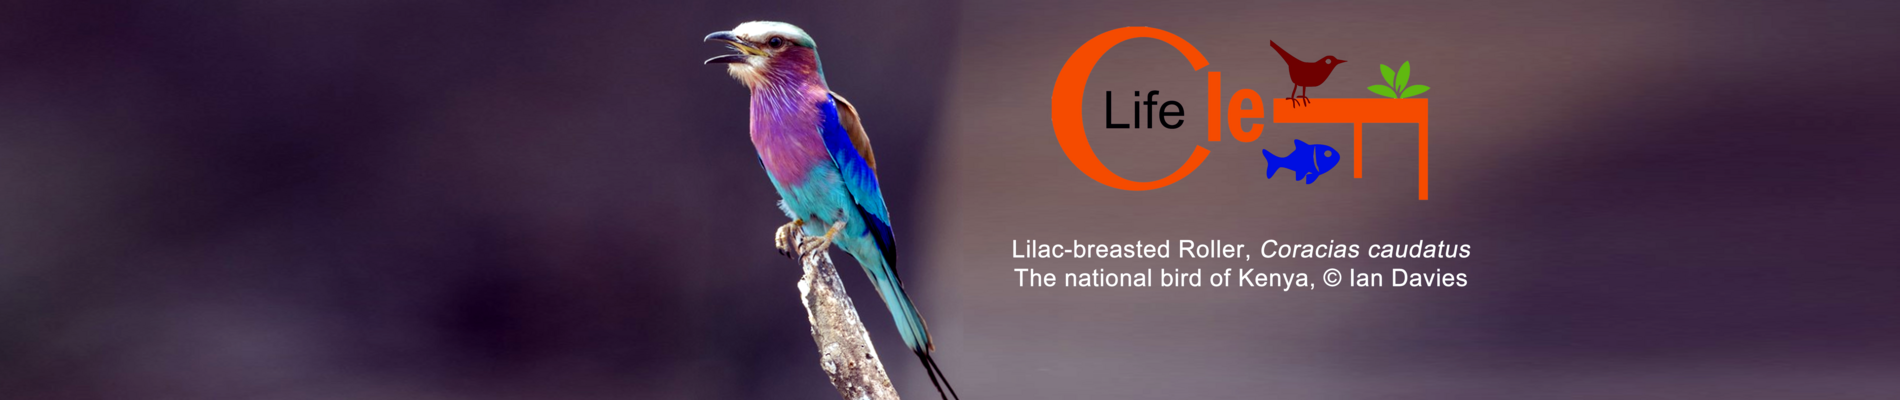

**Below is a summary of the main functions, techniques and tools used in this audio classification script.**

***1. Functions for loading and processing audio and metadata files:***

load_metadata: Loads the metadata of audio files from a CSV file.
process_audio_file: Processes an audio file, extracting audio segments and then computing the honey spectrogram and honey cepstral frequency coefficients (MFCCs) for each segment.
load_and_process_audio_files: Loads and processes audio files based on metadata and the selected species list.

***2. Model training and evaluation functions:***

train_model: Trains a random forest classifier model using random search and stratified cross-validation.
evaluate_model: Evaluates the performance of the model by calculating the accuracy of predictions.

***3. Functions for processing and previewing test audio files:***

process_test_audio_file: Processes a test audio file, extracting segments and computing the honey spectrogram and MFCCs for each segment.
predict: Make class probability predictions for a set of test features using the trained model.

***4. Main function that executes the complete flow of the script:***

Loads metadata and processes audio files.
Splits the data into training and testing sets.
Train and evaluate the model.
Saves and loads the trained model.
Processes a test audio file and makes predictions using the trained model.
Prepare and save a submission CSV file with forecasts.
The application is designed to classify different species of birds based on their vocalizations from audio files. The machine learning model used is a random forest classifier.

In [1]:
import os
import glob
import random
import concurrent.futures
import numpy as np
import pandas as pd 
import librosa
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from joblib import dump, load

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def load_metadata(file_path):
    """
    Carrega metadados de um arquivo CSV.

    Args:
        file_path (str): Caminho para o arquivo CSV contendo os metadados.

    Returns:
        DataFrame: Um DataFrame pandas contendo os metadados carregados.
    """
    return pd.read_csv(file_path)

def process_audio_file(filename, species, train_audio_path, segment_duration=5):
    """
    Processa um arquivo de áudio, dividindo-o em segmentos e extraindo características.

    Args:
        filename (str): Nome do arquivo de áudio.
        species (str): Espécie de pássaro associada ao arquivo de áudio.
        train_audio_path (str): Caminho para o diretório contendo os arquivos de áudio.
        segment_duration (int): Duração de cada segmento de áudio em segundos.

    Returns:
        list: Uma lista de tuplas contendo informações da espécie, nome do arquivo e características extraídas.
    """
    file_path = os.path.join(train_audio_path, species, filename)

    try:
        audio_data, sr = librosa.load(file_path)
    except Exception as e:
        print(f"Não foi possível carregar o arquivo {file_path}: {e}")
        return None

    segment_length = segment_duration * sr
    segments = [audio_data[i:i + segment_length] for i in range(0, len(audio_data), segment_length)]
    results = []

    for segment in segments:
        spectrogram = librosa.feature.melspectrogram(y=segment, sr=sr, n_mels=32)
        #spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sr, n_mels=64, n_fft=1024)
        mfccs = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=12)
        #mfccs = librosa.feature.mfcc(y=audio_data, sr=sr, n_mfcc=24, n_fft=1024)
        mean_mfccs = mfccs.mean(axis=1)
        file_features = np.concatenate([spectrogram.flatten(), mean_mfccs])

        results.append((species, filename, file_features))

    return results


def load_and_process_audio_files(metadata_df, selected_species_list, train_audio_path, sample_size=60):
    """
    Carrega e processa arquivos de áudio para as espécies selecionadas.

    Args:
        metadata_df (DataFrame): DataFrame contendo metadados.
        selected_species_list (list): Lista de espécies selecionadas para processamento.
        train_audio_path (str): Caminho para o diretório contendo os arquivos de áudio.
        sample_size (int): Número de amostras a serem processadas por espécie.

    Returns:
        tuple: Duas matrizes numpy, uma para características (X) e outra para rótulos (y).
    """
    audio_files = []

    for species in selected_species_list:
        species_path = os.path.join(train_audio_path, species, '*.ogg')
        species_audio_files = glob.glob(species_path)
        audio_files.extend([(os.path.basename(f), species) for f in species_audio_files])

    if len(audio_files) < sample_size:
        audio_files_sample = audio_files
    else:
        audio_files_sample = random.sample(audio_files, sample_size)

    results = []

    with concurrent.futures.ThreadPoolExecutor() as executor:
        results_list = list(
            executor.map(lambda x: process_audio_file(x[0], x[1], train_audio_path), audio_files_sample))

    for result in results_list:
        if result is not None:
            results.extend(result)

    species_list, filenames, features_list = zip(*results)

    max_features = max([len(features) for features in features_list])
    padded_features = []
    for features in features_list:
        padding_length = max(0, max_features - len(features))
        padded_features.append(np.pad(features, (0, padding_length), mode='constant'))

    results_df = pd.DataFrame({"primary_label": species_list, "filename": filenames})
    features_df = pd.DataFrame(padded_features, columns=[f"feature_{i}" for i in range(len(padded_features[0]))])

    metadata_features_df = pd.concat([results_df, features_df], axis=1)


    X = metadata_features_df.drop(["primary_label", "filename"], axis=1)
    y = metadata_features_df["primary_label"]

    return X, y


def train_model(X_train, y_train, param_dist, stratified_kfold, n_iter=300, n_jobs=-1):
    """
    Treina um modelo RandomForest usando busca aleatória em um conjunto de hiperparâmetros.

    Args:
        X_train (array): Matriz de características de treinamento.
        y_train (array): Vetor de rótulos de treinamento.
        param_dist (dict): Distribuição de hiperparâmetros para a busca aleatória.
        stratified_kfold (StratifiedKFold): Objeto StratifiedKFold para validação cruzada.
        n_iter (int): Número de iterações da busca aleatória.
        n_jobs (int): Número de jobs a serem executados em paralelo.

    Returns:
        RandomForestClassifier: O melhor classificador encontrado pela busca aleatória.
    """
    clf = RandomForestClassifier(random_state=42)

    random_search = RandomizedSearchCV(estimator=clf, param_distributions=param_dist, n_iter=n_iter,
                                       cv=stratified_kfold,
                                       verbose=2, random_state=42, n_jobs=n_jobs)

    random_search.fit(X_train, y_train)
    best_clf = random_search.best_estimator_

    return best_clf


def evaluate_model(model, X_test, y_test):
    """
    Avalia o modelo usando o conjunto de teste e retorna a acurácia.

    Args:
        model (RandomForestClassifier): Modelo a ser avaliado.
        X_test (array): Matriz de características de teste.
        y_test (array): Vetor de rótulos de teste.

    Returns:
        float: A acurácia do modelo.
    """
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)


def process_test_audio_file(filename, test_audio_path, segment_duration=5):
    file_path = os.path.join(test_audio_path, filename)

    try:
        audio_data, sr = librosa.load(file_path)
    except Exception as e:
        print(f"Não foi possível carregar o arquivo {file_path}: {e}")
        return None

    segment_length = segment_duration * sr
    segments = [audio_data[i:i + segment_length] for i in range(0, len(audio_data), segment_length)]
    results = []

    for segment in segments:
        spectrogram = librosa.feature.melspectrogram(y=segment, sr=sr, n_mels=32)
        mfccs = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=12)
        mean_mfccs = mfccs.mean(axis=1)
        file_features = np.concatenate([spectrogram.flatten(), mean_mfccs])

        results.append(file_features)

    return results

def predict(model, test_features, max_features, species_columns):
    test_padding_length = max(0, max_features - len(test_features))
    test_features_padded = np.pad(test_features, (0, test_padding_length), mode='constant')
    predictions = model.predict_proba(test_features_padded.reshape(1, -1))[0]

    class_probabilities = dict(zip(model.classes_, predictions))
    predictions_aligned = [class_probabilities.get(species, 0) for species in species_columns]

    return predictions_aligned


def main():
    metadata_file_path = os.path.join('birdclef2023/data/external/train_metadata.csv')
    metadata_df = load_metadata(metadata_file_path)

    selected_species_list = metadata_df["primary_label"].unique()
    train_audio_path = os.path.join('birdclef2023/data/external/train_audio')
    X, y = load_and_process_audio_files(metadata_df, selected_species_list, train_audio_path)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    param_dist = {
        'n_estimators': range(20, 400),
        'max_depth': [None] + list(range(1, 10)),
        'min_samples_split': range(2, 11),
        'min_samples_leaf': range(1, 5),
        'bootstrap': [True, False]
    }
    stratified_kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
    best_clf = train_model(X_train, y_train, param_dist, stratified_kfold)

    acc = evaluate_model(best_clf, X_test, y_test)
    print("Acurácia do modelo:", acc)

    test_audio_path = os.path.join('birdclef2023/data/external/test_soundscapes')
    test_filename = "soundscape_29201.ogg"
    test_features_list = process_test_audio_file(test_filename, test_audio_path)

    species_columns = sorted(metadata_df["primary_label"].unique())
    submission_df = pd.DataFrame(columns=['row_id'] + species_columns)

    for i, test_features in enumerate(test_features_list):
        if test_features is not None:
            predictions = predict(best_clf, test_features, X.shape[1], species_columns)

            temp_df = pd.DataFrame([predictions], columns=species_columns)
            test_filename_no_ext = os.path.splitext(test_filename)[0]
            temp_df.insert(0, "row_id", f"{test_filename_no_ext}_{(i + 1) * 5}")
            submission_df = submission_df.append(temp_df, ignore_index=True)
        else:
            print(f"Não foi possível processar o segmento {i + 1} do arquivo de áudio de teste.")

    submission_df.to_csv("birdclef2023/data/interim", index=False)


if __name__ == '__main__':
    main()

/opt/conda/lib/python3.10/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=541
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1603
  warnings.warn(


Fitting 4 folds for each of 300 candidates, totalling 1200 fits


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:1

[CV] END bootstrap=True, max_depth=8, min_samples_leaf=4, min_samples_split=7, n_estimators=378; total time=   8.5s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=3, min_samples_split=10, n_estimators=207; total time=   7.5s
[CV] END bootstrap=True, max_depth=9, min_samples_leaf=3, min_samples_split=7, n_estimators=92; total time=   2.2s
[CV] END bootstrap=False, max_depth=8, min_samples_leaf=4, min_samples_split=9, n_estimators=38; total time=   1.4s
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=4, min_samples_split=2, n_estimators=199; total time=   4.4s
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=1, min_samples_split=4, n_estimators=88; total time=   2.2s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=1, min_samples_split=9, n_estimators=52; total time=   1.6s
[CV] END bootstrap=True, max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=186; total time=   3.4s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_sam

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/tmp/ipykernel_20/157432594.py:162: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  submission_df = submission_df.append(temp_df, ignore_index=True)
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/tmp/ipykernel_20/157432594.py:162: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  submission_df = submission_df.append(temp_df, ignore_index=True)
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feat